- 1. Go to https://lobsterdata.com/info/DataSamples.php and download the 10 level data for amazon and microsoft
- 2. Save in a folder named 'data' where this file is saved.

In [50]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import os 
  
cwd=os.getcwd()

#The time component in the data is recorded in seconds after midnight.

startTrad = 9.5*60*60       # 9:30:00.000 in s after midnight
endTrad = 16*60*60        # 16:00:00.000 in s after midnight

# Message file information:
----------------------------------------------------------

  - Dimension:    (NumberEvents x 6)

  - Structure:    Each row:
                  Time stamp (sec after midnight with decimal
                  precision of at least milliseconds and
                  up to nanoseconds depending on the period),
                  Event type, Order ID, Size (# of shares),
                  Price, Direction

                  Event types:
                      - '1'   Submission new limit order
                      - '2'   Cancellation (partial)
                      - '3'   Deletion (total order)
                      - '4'   Execution of a visible limit order
                      - '5'   Execution of a hidden limit order
			- '7'   Trading Halt (Detailed 
                              information below)

                  Direction:
                      - '-1'  Sell limit order
                      - '1'  Buy limit order
                      - NOTE: Execution of a sell (buy)
                              limit order corresponds to
                              a buyer-(seller-) initiated
                              trade, i.e. a BUY (SELL) trade.

----------------------------------------------------------

This loads the data using Pandas. It filters for messages sent between 0930 and 1630.

In [17]:
def load_data(ticker='AMZN',time_format=False,startTrad=startTrad,endTrad=endTrad):

    #theMessageBookFileName = ticker+"_2012-06-21_34200000_57600000_message_10.csv"
    #theMessageBookFileName = os.path.join(cwd,"data",theMessageBookFileName)


    theMessageBook = pd.read_csv(ticker+"_2012-06-21_34200000_57600000_message_10.csv", names = ['Time','Type','OrderID','Size','Price','TradeDirection'])

    #we will need this for filtering the orderbook data#
    theMessageBook['row_index']=theMessageBook.index.values

    theMessageBookFiltered = theMessageBook[theMessageBook['Time'] >= startTrad] 
    theMessageBookFiltered = theMessageBookFiltered[theMessageBookFiltered['Time'] <= endTrad]
    
    if time_format:
        theMessageBookFiltered=theMessageBookFiltered.set_index(pd.to_datetime(theMessageBookFiltered.Time,unit='s'))
    
    return theMessageBookFiltered

In [18]:
msg_book_amzn=load_data(ticker='AMZN',time_format=True)
msg_book_msft=load_data(ticker='MSFT',time_format=True)

Check this has done what we think it should do:

In [19]:
msg_book_msft.head()

,Time,Type,OrderID,Size,Price,TradeDirection,row_index
Time,,,,,,,
1970-01-01 09:30:00.013994120,34200.013994,3,16085616,100,310400,-1,0
1970-01-01 09:30:00.013994120,34200.013994,1,16116348,100,310500,-1,1
1970-01-01 09:30:00.015247805,34200.015248,1,16116658,100,310400,-1,2
1970-01-01 09:30:00.015442111,34200.015442,1,16116704,100,310500,-1,3
1970-01-01 09:30:00.015789148,34200.015789,1,16116752,100,310600,-1,4


In [20]:
msg_book_msft.tail()

,Time,Type,OrderID,Size,Price,TradeDirection,row_index
Time,,,,,,,
1970-01-01 15:59:59.861465727,57599.861466,3,287081309,9249,301400,-1,668760
1970-01-01 15:59:59.861566671,57599.861567,3,287117122,783,301400,-1,668761
1970-01-01 15:59:59.873177404,57599.873177,3,287070525,800,301500,-1,668762
1970-01-01 15:59:59.907796528,57599.907797,5,0,100,301350,-1,668763
1970-01-01 15:59:59.907796528,57599.907797,5,0,300,301350,-1,668764


How many events in this trading day:

In [21]:
print(msg_book_msft.shape)
print(msg_book_amzn.shape)

(668765, 7)
(269748, 7)


What is the distribution of events?

In [22]:
#   - '1'   Submission new limit order
#   - '2'   Cancellation (partial)
#   - '3'   Deletion (total order)
#   - '4'   Execution of a visible limit order
#   - '5'   Execution of a hidden limit order
def summary(msg_book):
    summary=msg_book.groupby('Type')['Size'].agg(['count','sum'])
    summary=summary/summary.sum()
    summary['description']=summary.index.map({1:'New LO',2:'Cancel',3:'Deletion',4:'Execution visible',5:'Execution hidden'})
    return summary

In [23]:
summary(msg_book_msft)

,count,sum,description
Type,,,
1,0.492798,0.503541,New LO
2,0.008377,0.006280,Cancel
3,0.448862,0.458995,Deletion
4,0.044557,0.028486,Execution visible
5,0.005407,0.002699,Execution hidden


In [25]:
summary(msg_book_amzn)

,count,sum,description
Type,,,
1,0.489175,0.498550,New LO
2,0.010814,0.013223,Cancel
3,0.457679,0.457200,Deletion
4,0.033268,0.023469,Execution visible
5,0.009064,0.007558,Execution hidden


Check for trading halts.

----------------------------------------------------------
When trading halts, a message of type '7' is written into the 
'message' file. The corresponding price and trade direction 
are set to '-1' and all other properties are set to '0'. 

Should the resume of quoting be indicated by an additional 
message in NASDAQ's Historical TotalView-ITCH files, another 
message of type '7' with price '0' is added to the 'message' 
file. Again, the trade direction is set to '-1' and all other 
fields are set to '0'.

When trading resumes a message of type '7' and 
price '1' (Trade direction '-1' and all other 
entries '0') is written to the 'message' file. 

For messages 
of type '7', the corresponding order book rows contain a 
duplication of the preceding order book state. The reason 
for the trading halt is not included in the output.

Example: Stylized trading halt messages in 'message' file.				

Halt: 			36023	| 7 | 0 | 0 | -1 | -1
                                    ...
Quoting: 		36323 	| 7 | 0 | 0 | 0  | -1
                                    ...
Resume Trading:		36723   | 7 | 0 | 0 | 1  | -1
                                    ...
The vertical bars indicate the different columns in the message file.

In [26]:
def check_for_halts(theMessageBookFiltered):

    # Note: As the rows of the message and orderbook file correspond to each other, the time index of
    # the message file can also be used to 'cut' the orderbook file.

    # Check for trading halts Rcode (left untouched for now)
    # ----------------------------------------------------------
    tradingHaltIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.TradeDirection == -1)]

    tradeQuoteIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.TradeDirection == 0)]

    tradeResumeIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.TradeDirection == 1)]

    if (len(tradingHaltIdx) == 0 | len(tradeQuoteIdx) == 0  | len(tradeResumeIdx) == 0):
        print("No trading halts detected.")

    if(len(tradingHaltIdx) != 0):
        print("Data contains trading halt! at time stamp(s): "); print(list(tradingHaltIdx))

    if(len(tradeQuoteIdx) != 0):
        print(" Data contains quoting message! at time stamp(s)"); print(list(tradeQuoteIdx)) 

    if(len(tradeResumeIdx) != 0):
        print(" Data resumes trading! at time stamp(s) "); print(list(tradeResumeIdx))

In [27]:
check_for_halts(msg_book_amzn)
check_for_halts(msg_book_msft)

No trading halts detected.
No trading halts detected.


# Plot - Number of Executions and Trade Volume by Interval
_____________________________________________________________________________
              
Note: Difference between trades and executions

   The LOBSTER output records limit order executions
   and not what one might intuitively consider trades.

   Imagine a volume of 1000 is posted at the best ask
   price. Further, an incoming market buy order of
   volume 1000 is executed against the quote.

   The LOBSTER output of this trade depends on the
   composition of the volume at the best ask price.
   Take the following two scenarios with the best ask
 	 volume consisting of ...
   	(a) 1 sell limit order with volume 1000
   	(b) 5 sell limit orders with volume 200 each
      	(ordered according to time of submission)

    The LOBSTER output for case ...
      (a) shows one execution of volume 1000. If the
          incoming market order is matched with one
          standing limit order, execution and trade
          coincide.
      (b) shows 5 executions of volume 200 each with the
          same time stamp. The incoming order is matched
          with 5 standing limit orders and triggers 5
          executions.

  Bottom line:
      LOBSTER records the exact limit orders against
      which incoming market orders are executed. What
      might be called 'economic' trade size has to be
      inferred from the executions.

In [28]:
def visible_invisible_plot(df_in,ticker,rolling_seconds=300):
    #to resample we need to set index to a time index
    try:
        assert type(df_in.index)==pd.core.indexes.datetimes.DatetimeIndex
        
    except AssertionError:
        df=df_in.set_index(pd.to_datetime(df_in.Time,unit='s'))
    df=pd.DataFrame(df_in)
        
    #only select the trade executions
    df=df[df.Type.isin([4,5])]


    #separate out the data of interest into separate columns, use fact that true =1 and  false=0
    df['Visible']=df.Type==4
    df['Visible size']=df['Visible']*df['Size']

    df['Invisible']=-1*(df.Type==5) #-1 multiplier to flip hidden trades on x axis.
    df['Invisible size']=df['Invisible']*df['Size']

    #resample data into 5 minute intervals, sum contents of each time bucket.
    resampled_data=df.resample(str(rolling_seconds)+'S',label='right').sum()


    #create a subplot with two axes which shares the x -time axis
    fig,axs=plt.subplots(2,1,sharex=True,figsize=(10,6))

    #using the plotting backend in pandas (pyplot by default)
    resampled_data[['Visible','Invisible']].plot(ax=axs[0],kind='area',color = ('#fc0417','#0c04fc'))
    axs[0].set_ylabel('Number of Executions')

    resampled_data[['Visible size','Invisible size']].plot(ax=axs[1],kind='area',color = ('#fc0417','#0c04fc'))
    _=axs[1].set_ylabel('Quantity of executions')
    
    axs[0].set_title(f'Invisible visible executions for {ticker} over {str(rolling_seconds)} sec rolling period')
    
    return resampled_data

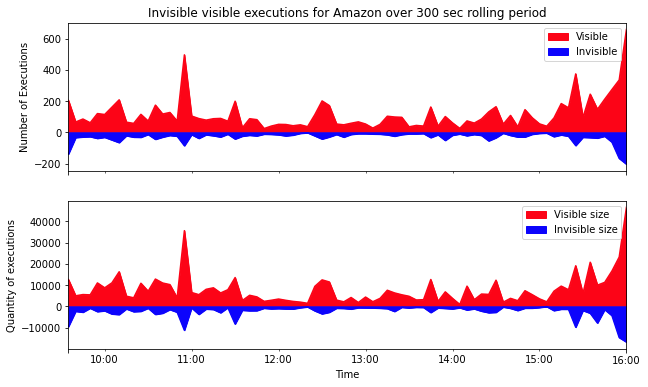

In [30]:
rsd_amzn=visible_invisible_plot(msg_book_amzn,"Amazon")

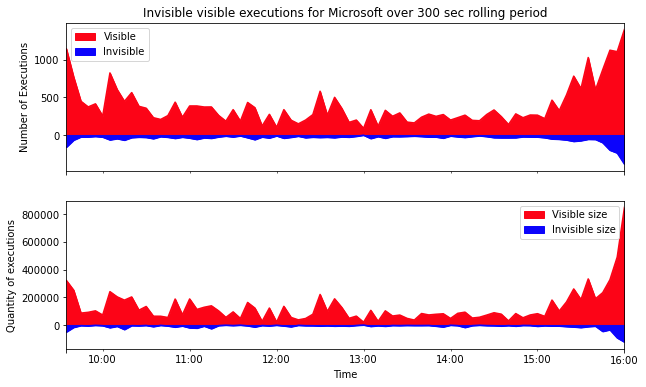

In [31]:
rsd_msft=visible_invisible_plot(msg_book_msft,"Microsoft")

Text(0.5, 1.0, 'Hidden order volume as % of total volume 5min rolling average')

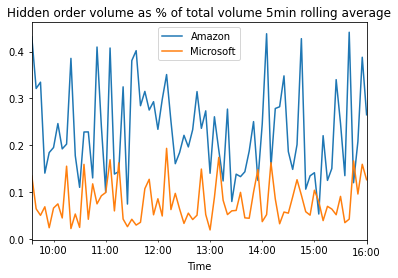

In [32]:
ax=(-1*rsd_amzn['Invisible size']/rsd_amzn['Size']).plot(label='Amazon')
(-1*rsd_msft['Invisible size']/rsd_msft['Size']).plot(ax=ax,label='Microsoft')
ax.legend()
ax.set_title('Hidden order volume as % of total volume 5min rolling average')

Now we are going to look at the order book data.

# Orderbook file information:
----------------------------------------------------------

  - Dimension:    (NumberEvents x (NumberLevels*4))

  - Structure:    Each row:
                  Ask price 1, Ask volume 1, Bid price 1,
                  Bid volume 1, Ask price 2, Ask volume 2,
                  Bid price 2, Bid volume 2, ...

  - Note:         Unoccupied bid (ask) price levels are
                  set to -9999999999 (9999999999) with volume 0.
				      
----------------------------------------------------------

In [33]:
def loadOrderBook(theMessageBook,ticker='AMZN'):
    #_____________________________________________________________________________
    #
    # Load Order Book File
    # This is going to output a dictionary of four dataframes - asks/bids prices/sizes
    #It will be indexed by the time index formed from the messagebook df
    #_____________________________________________________________________________
    nlevels = 10

    # Load data
    theOrderBookFileName = ticker+"_2012-06-21_34200000_57600000_orderbook_10.csv"
    theOrderBookFileName=os.path.join(cwd,"data",theOrderBookFileName)
    print(theOrderBookFileName)

    col = ['Ask Price ','Ask Size ','Bid Price ','Bid Size ']
    theNames=[str(col_name)+str(level_no)  for level_no in range(1,nlevels+1) for col_name in col ]

    theOrderBook = pd.read_csv(theOrderBookFileName, names = theNames)
        
    #timeIndex = theMessageBook.index[(theMessageBook.Time >= startTrad) & (theMessageBook.Time <= endTrad)]
    #theOrderBookFiltered = theOrderBook[theOrderBook.index == timeIndex]
        
    theOrderBookFiltered = theOrderBook.iloc[theMessageBook.row_index]
    
    #theOrderBookFiltered=theOrderBookFiltered.set_index(pd.to_datetime(theMessageBook.Time,unit='s'))
    theOrderBookFiltered=theOrderBookFiltered.set_index(theMessageBook.index)
    
    # Convert prices into dollars
    #    Note: LOBSTER stores prices in dollar price times 10000

    col = ['Ask Price ','Ask Size ','Bid Price ','Bid Size ']

    #separate the four types of column into a dictionary with key=column type
    data_col_dic={c.strip():[c+str(level_no)  for level_no in range(1,nlevels+1)] for c in col}

    #separate data into four aligned dataframes of the four different types of data with key=data type
    data_dic={c:theOrderBookFiltered[cols] for c,cols in data_col_dic.items()}
      
    return data_dic

In [34]:
OB_dic_amzn=loadOrderBook(msg_book_amzn,ticker='AMZN')

OB_dic_msft=loadOrderBook(msg_book_msft,ticker='MSFT')

/Users/parthparakh/Plan20-21/Codes/MicroStructure/LOBSTER_SampleFile_MSFT_2012-06-21_10/data/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv
/Users/parthparakh/Plan20-21/Codes/MicroStructure/LOBSTER_SampleFile_MSFT_2012-06-21_10/data/MSFT_2012-06-21_34200000_57600000_orderbook_10.csv


The output is a dictionary of dataframes. Each row of this dataset should refer to the orderbook state after a new event has happened. So it should be the same length. Let us check that.

In [35]:
def data_checker(OB_dic,msg_book):

    for k,val in OB_dic.items():
        
        assert val.shape[0]==msg_book.shape[0]
        print("ok!",k,type(val),val.shape)
    
data_checker(OB_dic_amzn,msg_book_amzn)
data_checker(OB_dic_msft,msg_book_msft)

ok! Ask Price <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Ask Size <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Bid Price <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Bid Size <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Ask Price <class 'pandas.core.frame.DataFrame'> (668765, 10)
ok! Ask Size <class 'pandas.core.frame.DataFrame'> (668765, 10)
ok! Bid Price <class 'pandas.core.frame.DataFrame'> (668765, 10)
ok! Bid Size <class 'pandas.core.frame.DataFrame'> (668765, 10)


In [36]:
def order_book_look(OB_dic,ticker,random_no=None):
    # Note: Pick a random row/event from the order book if not specified
    
    if random_no is None:
        random_no = OB_dic['Bid Size'].sample().index[0]
    else:
        #first appearing event after the given time
        random_no=OB_dic['Bid Size'][OB_dic['Bid Size'].index>random_no].index[0]
      
    time=random_no.strftime('%H:%M:%S:%f')

    #
    # Plot 1 - Snapshot of the Limit Order Book
    #_____________________________________________________________________________

    fig,ax=plt.subplots(2,1,figsize=(9,9)) 

    bid_data=OB_dic['Bid Size'].loc[random_no]
    bid_prices=OB_dic['Bid Price'].loc[random_no]

    ask_data=OB_dic['Ask Size'].loc[random_no]
    ask_prices=OB_dic['Ask Price'].loc[random_no]


    ax[0].bar(ask_prices/10000,ask_data,
           width=0.007, color='#fc1b04', label='Ask')

    ax[0].bar(bid_prices/10000,bid_data,
           width=0.007,color='#13fc04', label='Bid')

    ax[0].set_ylabel('Quantity')
    ax[0].set_xlabel('Price($)')
    ax[0].set_title(f'Order book at {str(time)} for {ticker}')
    #_____________________________________________________________________________
    #
    # Plot 2 - Relative Depth in the Limit Order Book
    #_____________________________________________________________________________
    # Plot variables
    ax[1].step(range(1,11,1),bid_data.cumsum()/bid_data.sum(),label='Bid',color='#13fc04')
    ax[1].step(range(1,11,1),-1*ask_data.cumsum()/ask_data.sum(),label='Ask',color='#fc1b04')

    ax[1].set_ylim(-1,1)
    ax[1].set_xlim(1,10)
    #ax[1].set_title('Relative Depth in the Limit Order Book for ' + ticker + ' at ' + str(time))
    ax[1].set_ylabel('% Orderbook')
    ax[1].set_xlabel('Level')
    
    return random_no

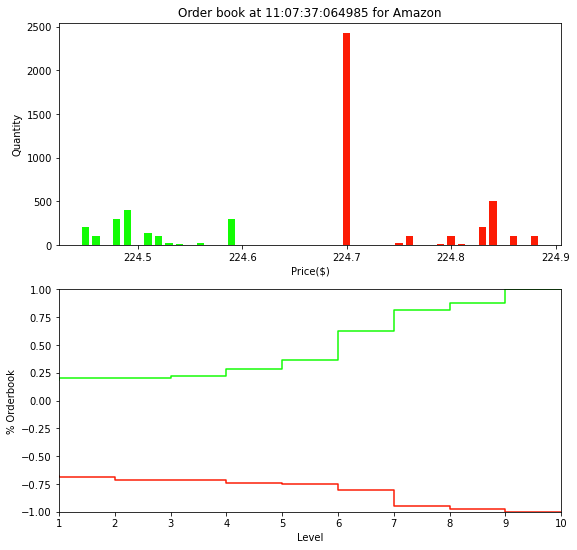

In [37]:
time=order_book_look(OB_dic_amzn,'Amazon')

Timestamp('1970-01-01 11:15:35.075001537')

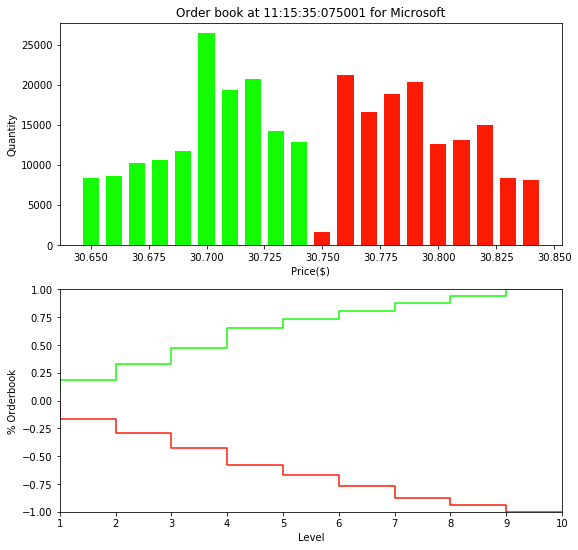

In [35]:
order_book_look(OB_dic_msft,'Microsoft',time)

# Event time vs time time

Event time is expressed as the sequence of events that occur to the limit order book. Sometimes it is convenient to think about of this as time instead of normal time. 

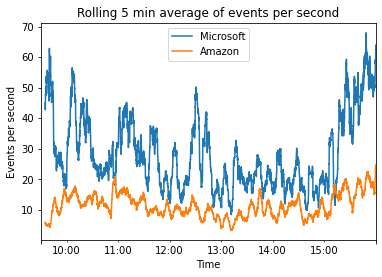

In [38]:
ax=msg_book_msft.resample("1S").count()['Time'].rolling(300).mean().plot(label='Microsoft',legend=True)
msg_book_amzn.resample("1S").count()['Time'].rolling(300).mean().plot(label='Amazon',legend=True,ax=ax,title='Rolling 5 min average of events per second')
_=ax.set_ylabel('Events per second')

# Empirical properties of the LOB - large and small tick stocks

Now we are going to look at how a large tick stock - Microsoft differs from a small tick stock - Amazon.

In [39]:
def spread_plot(OB_dic,ticker,rolling_unit=2000):
    #This plots the spread at best varies over the day.

    spread=pd.DataFrame((OB_dic['Ask Price']['Ask Price 1']-OB_dic['Bid Price']['Bid Price 1']),columns=['spread'])
    #spread['normalised_spread_bps']=10000*0.5*spread['spread']/(OB_dic['Ask Price']['Ask Price 1']+OB_dic['Bid Price']['Bid Price 1'])

    
    ax=spread.plot()
    
    spread_res=spread.resample(str(rolling_unit)+'S',label='right').mean()
    spread_res.columns=[str(rolling_unit)+'S mavg']
    spread_res.plot(ax=ax,legend=True)
    
    ax.set_title(f'Spread over day of {ticker} in bps')
    
    myFmt=DateFormatter("%H:%m")
    ax.xaxis.set_major_formatter(myFmt)
    return spread

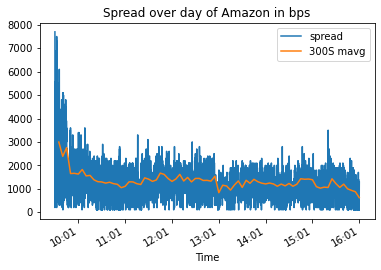

In [40]:
    
df=spread_plot(OB_dic_amzn,'Amazon',rolling_unit=300)

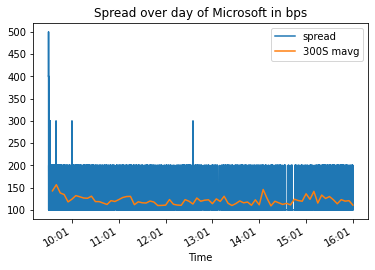

In [41]:
df=spread_plot(OB_dic_msft,'Microsoft',rolling_unit=300)

In [42]:
def depth_at_best_plot(OB_dic,ticker,events=2000,resample_per=300):
    
    
    depth=pd.DataFrame(OB_dic['Ask Size']['Ask Size 1'])
    depth.columns=['Best ask depth']
    
    #average of last 2000 quotes - might not be time consistent
    
    depth[str(events)+ ' event mavg']=depth.rolling(events).mean()
    ax=depth.plot()
    
    res_per=str(resample_per)+'S'
    depth_res=depth.resample(res_per,label='right').mean()
    depth_res.columns=[res_per+ ' mavg','_']
    depth_res[res_per+ ' mavg'].plot(ax=ax,legend=True)

    ax.set_title(f'Depth over day of {ticker}')
    ax.set_ylabel('Shares')
    
    return depth_res 

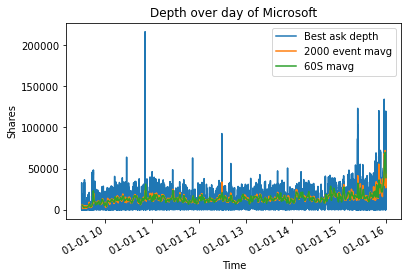

In [43]:
df=depth_at_best_plot(OB_dic_msft,'Microsoft',events=2000,resample_per=60)

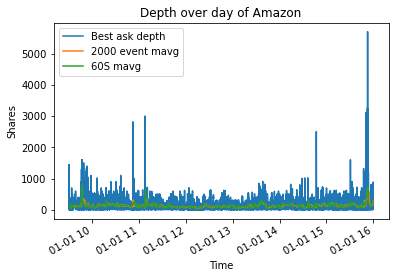

In [44]:
df=depth_at_best_plot(OB_dic_amzn,'Amazon',events=2000,resample_per=60)

In [45]:
def plot_net_limit_orders(msg_book,ticker):

    #filter out executions to leave LOs, cancels and deletes
    net_limit_orders=msg_book[msg_book.Type.isin([1,2,3])]
    
    net_limit_orders=net_limit_orders.set_index(pd.to_datetime(net_limit_orders.Time,unit='s'))
    
    #create a column =1 if a LO and  -1 if a delete cancel
    net_limit_orders['accrete_deplete']=net_limit_orders.Type.map({1:1,2:-1,3:-1})
    #multiply with quantity to get signed LO quantity
    net_limit_orders['signed_size']=net_limit_orders['accrete_deplete']*net_limit_orders['Size']
    #    Note: LOBSTER stores prices in dollar price times 10000
    net_limit_orders['signed_volume']=net_limit_orders['signed_size']*net_limit_orders['Price']/10000

    #resample time series into 5 minute intervals, sum over each 5 minutes, units of US$m and plot
    ax=(net_limit_orders.signed_volume.resample('300S',label='right').sum()/1000000).plot()
    ax.set_title(f"Net limit orders {ticker}")
    ax.set_ylabel('5 min LO net volume (m$)')
    

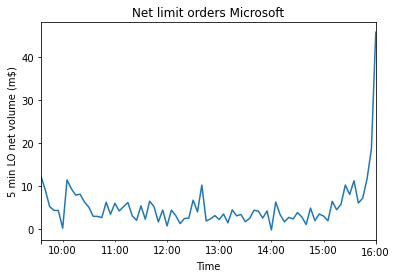

In [46]:
plot_net_limit_orders(msg_book_msft,"Microsoft")

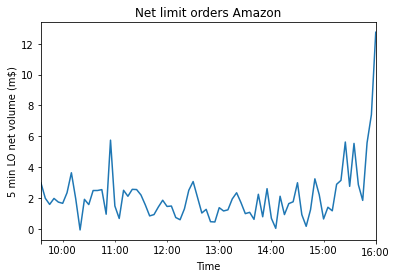

In [47]:
plot_net_limit_orders(msg_book_amzn,"Amazon")

# Event rates in the LOB

In [48]:
#get all of the LO submissions

def abs_dist(price,side,best_ask,best_bid):
    #little function to get absolute distance to best depending on order type
    if side==1:
        return best_bid-price
    elif side==-1:
        return price-best_ask



def event_rate(msg_book,OB_dic,Type=1):
    events=msg_book[msg_book.Type.isin([1])]
    
    #get the raw information we need from the Orderbook 
    Best_state=pd.DataFrame({'Best_bid':OB_dic['Bid Price']['Bid Price 1'],
                             'Best_ask':OB_dic['Ask Price']['Ask Price 1']})
    
    #we want to know the state of the order book before submission of an order
    Best_state['prev_Best_bid']=Best_state.Best_bid.shift(1)
    Best_state['prev_Best_ask']=Best_state.Best_ask.shift(1)
    Best_state.fillna(0,inplace=True)

    #not necessary but this column return true if the best bid/ask has improved
    Best_state['Bid_improved']=Best_state['Best_bid']>Best_state['prev_Best_bid']
    Best_state['Ask_improved']=Best_state['Best_ask']<Best_state['prev_Best_ask']
    
    #merge the order book information with the message information    
        #events=events.merge(Best_state.iloc[events.row_index],left_on='row_index',right_on='row_index')
    #prefer concat because we know the rows are aligned. merge may get into trouble for simultaneous events.
    events=pd.concat([events,Best_state.iloc[events.row_index]],sort=False,axis=1)
    
    #apply absolute distance calculation row by row. 
    #This is slow way to do it but 
    events['abs_dist']=events.apply(lambda x: abs_dist(x['Price'],x['TradeDirection'],x['prev_Best_ask'],
                                                       x['prev_Best_bid']),axis=1 )
    
    
    
    return events


This is this the distribution of LO submissions wrt their absolute distance from best.

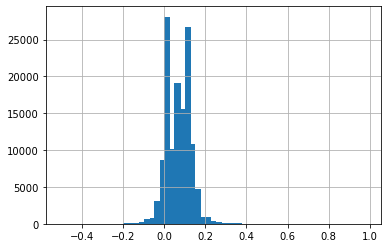

In [51]:
events_amzn=event_rate(msg_book_amzn,OB_dic_amzn,1)
(events_amzn['abs_dist']/10000).hist(bins=np.arange(-.5,1,0.025).round(2))

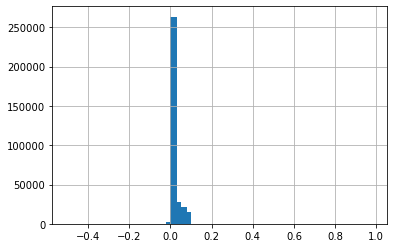

In [52]:
events_msft=event_rate(msg_book_msft,OB_dic_msft,1)
(events_msft['abs_dist']/10000).hist(bins=np.arange(-.5,1,0.025).round(2))

Note that there are LOs with negative absolute distance? These are best improving orders (bid above best or ask below)

In [53]:
bi=(events_msft.Bid_improved | events_msft.Ask_improved).value_counts()
bi/bi.sum()

False    0.993843
True     0.006157
dtype: float64

In [54]:
bi=events_amzn.Bid_improved.value_counts()
bi/bi.sum()

False    0.949899
True     0.050101
Name: Bid_improved, dtype: float64